# Frequent Itemset Mining and Association Rule Learning

----

Author: [**Mirko M. Stojiljković**, Ph.D.](http://mmst.tech/)

Version: **1.0**

Last updated: **01 May 2019**

License: [**MIT**](https://opensource.org/licenses/MIT)

---

Copyright 2019 Mirko Stojiljković

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

----

Dataset: "**FIFA 19 complete player dataset**" available at [kaggle.com](https://www.kaggle.com/karangadiya/fifa19) under the [CC BY-NC-SA 4.0 license](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
import re

import apyori
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

**Import data**

In [2]:
data = pd.read_csv('data.csv',
                   usecols=['Age', 'Overall', 'Potential', 'Value', 'Wage',
                            'Preferred Foot', 'International Reputation',
                            'Position', 'Height', 'Weight', 'Crossing',
                            'Finishing', 'HeadingAccuracy', 'ShortPassing',
                            'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
                            'LongPassing', 'BallControl', 'Acceleration',
                            'SprintSpeed', 'Agility', 'Reactions', 'Balance',
                            'ShotPower', 'Jumping', 'Stamina', 'Strength',
                            'LongShots', 'Aggression', 'Interceptions',
                            'Positioning', 'Vision', 'Penalties', 'Composure',
                            'Marking', 'StandingTackle', 'SlidingTackle'])

pattern = re.compile(r'(.)([A-Z][a-z]+)')
data.columns = [re.sub(pattern, r'\1_\2', item).lower().replace(' ', '')
                for item in data.columns]

# data

**Remove the goalkeepers and the players with `overall` < 80**

In [3]:
data = data[(data['position'] != 'GK') & (data['overall'] >= 80)]

# data

**Convert `value`, `wage`, `height`, and `weight` to floating-point numbers**

In [4]:
cols = ['value', 'wage', 'height', 'weight']
x = {item: data[item].values.astype(np.unicode_) for item in cols}

chars = {'value': ('€', 'M'), 'wage': ('€', 'K'), 'weight': ('lbs')}
for k, v in chars.items():
    for item in v:
        x[k] = np.char.replace(x[k], item, '')
for k in chars:
    x[k] = x[k].astype(float)
x['weight'] *= 0.45  # in kg

x['height'] = np.char.split(x['height'], sep='\'')
x['height'] = np.fromiter((12 * int(y) + int(z) for y, z in x['height']),
                          dtype=float, count=len(x['height']))
x['height'] *= 2.54  # in cm

for item in cols:
    data.loc[:, item] = x[item]

# data

In [5]:
np.corrcoef(data['overall'], data['value'])

array([[1.        , 0.86498523],
       [0.86498523, 1.        ]])

In [6]:
np.corrcoef(data['overall'], data['wage'])

array([[1.        , 0.78474581],
       [0.78474581, 1.        ]])

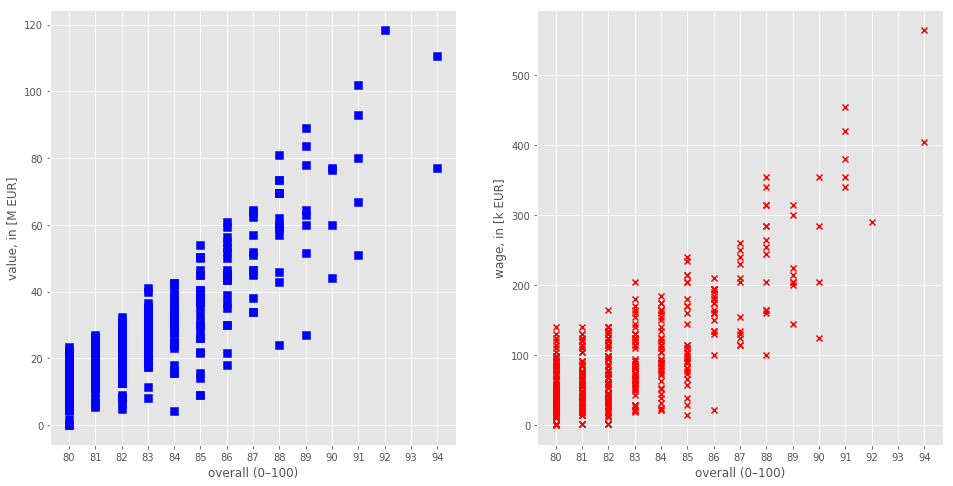

In [7]:
plt.style.use('ggplot')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].scatter(data['overall'], data['value'], color='blue', marker='s', s=60)
axes[0].set_ylabel('value, in [M EUR]')
axes[1].scatter(data['overall'], data['wage'], color='red', marker='x')
axes[1].set_ylabel('wage, in [k EUR]')
for item in axes:
    item.xaxis.set(ticks=np.arange(80, 95))
    item.set_xlabel('overall (0–100)')
plt.show()

**Get basic descriptive statistics**

In [8]:
stats = data.describe()

stats

,age,overall,potential,value,wage,international_reputation,height,weight,crossing,finishing,...,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle
count,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,...,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000
mean,27.395492,82.579918,84.323770,26.069057,91.506148,2.510246,181.256066,75.622131,69.887295,65.493852,...,68.934426,70.834016,63.151639,70.426230,73.420082,64.772541,79.059426,63.165984,62.401639,58.577869
std,3.643416,2.678105,3.343707,16.705250,76.433004,0.847691,6.735493,7.334994,13.679434,17.000663,...,15.432565,13.363621,21.640367,16.511171,11.824945,13.366248,5.481962,19.869986,22.868038,23.879877
min,18.000000,80.000000,80.000000,0.000000,0.000000,1.000000,162.560000,58.500000,17.000000,10.000000,...,12.000000,23.000000,16.000000,20.000000,22.000000,23.000000,60.000000,10.000000,13.000000,12.000000
25%,25.000000,80.000000,82.000000,15.500000,38.750000,2.000000,175.260000,69.300000,62.000000,54.000000,...,62.000000,62.000000,42.000000,64.000000,68.000000,56.000000,75.000000,46.000000,41.000000,34.750000
50%,27.000000,82.000000,84.000000,21.250000,73.000000,3.000000,180.340000,75.600000,74.000000,70.000000,...,74.000000,73.500000,74.000000,76.500000,77.000000,67.000000,79.000000,69.000000,73.000000,68.000000
75%,30.000000,84.000000,87.000000,30.500000,120.000000,3.000000,185.420000,80.550000,80.000000,78.250000,...,80.000000,81.000000,81.000000,81.000000,82.000000,75.000000,83.000000,80.000000,82.000000,80.000000
max,37.000000,94.000000,95.000000,118.500000,565.000000,5.000000,198.120000,99.000000,93.000000,95.000000,...,94.000000,94.000000,92.000000,95.000000,94.000000,92.000000,96.000000,94.000000,93.000000,91.000000


In [9]:
foots = set(data['preferred_foot'])
positions = set(data['position'])

foots, positions

({'Left', 'Right'},
 {'CAM',
  'CB',
  'CDM',
  'CF',
  'CM',
  'LAM',
  'LB',
  'LCB',
  'LCM',
  'LDM',
  'LF',
  'LM',
  'LS',
  'LW',
  'LWB',
  'RAM',
  'RB',
  'RCB',
  'RCM',
  'RDM',
  'RF',
  'RM',
  'RS',
  'RW',
  'RWB',
  'ST'})

**Create a new dataframe where numeric values are replaced with the indices of the quartiles they belong to**

In [10]:
data_ = pd.DataFrame(index=data.index, columns=data.columns)

data_['preferred_foot'] = np.where(data['preferred_foot']=='Right', 'R', 'L')

is_attacker = np.isin(data['position'], ['CF', 'LF', 'LS', 'RF', 'RS', 'ST'])
is_midfielder = np.isin(data['position'],
                        ['CAM', 'CDM', 'CM', 'LAM', 'LCM', 'LDM', 'LM', 'LW',
                         'RAM', 'RCM', 'RDM', 'RM', 'RW'])
is_defender = np.isin(data['position'],
                      ['CB', 'LB', 'LCB', 'LWB', 'RB', 'RCB', 'RWB'])

data_['position'][is_attacker] = 'A'
data_['position'][is_midfielder] = 'M'
data_['position'][is_defender] = 'D'

for item in stats:
    # quartiles = np.quantile(data[item], (0.25, 0.5, 0.75))
    quartiles = stats.loc[['25%', '50%', '75%'], item].values
    data_[item] = np.searchsorted(quartiles, data[item]) + 1

# data_

**Create the list of transactions for the accociation rule learning**

In [11]:
tr = [[f'{item}={data_.at[i, item]}' for item in data.columns]
      for i in data.index]

# tr

**Perform the association rule learning**

In [12]:
results = apyori.apriori(tr, min_support=0.2, min_confidence=0.8,
                         min_lift=1.0, max_length=None)

for i, result in enumerate(results):
    items = set(result.items)
    if len(items) == 1:
        continue
    i_ = i + 1
    print('result', f'{i_}:')
    print('items:', items)
    print('support:', result.support)
    for j, item in enumerate(result.ordered_statistics):
        print('rule', f'{i_}.{j+1}:', set(item.items_base), '=>',
              set(item.items_add))
        print('    confidence:', item.confidence)
        print('    lift:      ', item.lift)
    print()

result 1:
items: {'preferred_foot=R', 'acceleration=1'}
support: 0.2336065573770492
rule 1.1: {'acceleration=1'} => {'preferred_foot=R'}
    confidence: 0.8382352941176472
    lift:       1.1299967500812482

result 2:
items: {'balance=1', 'agility=1'}
support: 0.21721311475409835
rule 2.1: {'agility=1'} => {'balance=1'}
    confidence: 0.8153846153846153
    lift:       3.1579975579975574
rule 2.2: {'balance=1'} => {'agility=1'}
    confidence: 0.8412698412698412
    lift:       3.1579975579975574

result 3:
items: {'preferred_foot=R', 'agility=1'}
support: 0.2192622950819672
rule 3.1: {'agility=1'} => {'preferred_foot=R'}
    confidence: 0.823076923076923
    lift:       1.1095622609434763

result 4:
items: {'height=4', 'balance=1'}
support: 0.20081967213114754
rule 4.1: {'height=4'} => {'balance=1'}
    confidence: 0.8099173553719008
    lift:       3.136822773186409

result 5:
items: {'preferred_foot=R', 'balance=1'}
support: 0.2069672131147541
rule 5.1: {'balance=1'} => {'preferred

Some interesting observations:

----

`rule 4.1: {'height=4'} => {'balance=1'}`

Tall players tend to have poor balance

----

`rule 6.1: {'ball_control=1'} => {'dribbling=1'}`

Poor ball control indicates that dribbling is poor as well

----

`rule 7.1: {'ball_control=1'} => {'position=D'}`

Poor ball control indicates that a player is likely a defender

----

`rule 14.1: {'dribbling=1'} => {'position=D'}`

Poor dribbling indicates that a player is likely a defender

----

`rule 22.1: {'heading_accuracy=1'} => {'position=M'}`

Midfielders tend to have poor heading accuracies

----

`rule 41.2: {'dribbling=1', 'positioning=1'} => {'position=D'}`

Poor dribbling and positioning indicates that a player is likely a defender

----

`rule 41.3: {'positioning=1', 'position=D'} => {'dribbling=1'}`

Defenders with poor positioning almost always have poor dribbling

In [13]:
results = apyori.apriori(tr, min_support=0.1, min_confidence=0.8,
                         min_lift=1.0, max_length=None)

for i, result in enumerate(results):
    items = set(result.items)
    if len(items) == 1:
        continue
    if 'wage=4' not in items:
        continue
    i_ = i + 1
    print('result', f'{i_}:')
    print('items:', items)
    print('support:', result.support)
    for j, item in enumerate(result.ordered_statistics):
        print('rule', f'{i_}.{j+1}:', set(item.items_base), '=>',
              set(item.items_add))
        print('    confidence:', item.confidence)
        print('    lift:      ', item.lift)
    print()

result 1785:
items: {'overall=4', 'wage=4', 'reactions=4'}
support: 0.11270491803278689
rule 1785.1: {'overall=4', 'reactions=4'} => {'wage=4'}
    confidence: 0.8088235294117648
    lift:       3.316856154226397
rule 1785.2: {'wage=4', 'reactions=4'} => {'overall=4'}
    confidence: 0.8870967741935484
    lift:       4.417379855167874

result 1786:
items: {'value=4', 'overall=4', 'wage=4'}
support: 0.13114754098360656
rule 1786.1: {'overall=4', 'wage=4'} => {'value=4'}
    confidence: 0.8767123287671234
    lift:       3.535831540812861
rule 1786.2: {'value=4', 'wage=4'} => {'overall=4'}
    confidence: 0.8533333333333334
    lift:       4.249251700680272

result 1904:
items: {'value=4', 'potential=4', 'wage=4'}
support: 0.10040983606557377
rule 1904.1: {'potential=4', 'wage=4'} => {'value=4'}
    confidence: 0.9423076923076924
    lift:       3.8003814367450737

result 1921:
items: {'value=4', 'wage=4', 'reactions=4'}
support: 0.10860655737704918
rule 1921.1: {'wage=4', 'reactions=4'

Some interesting observations:

----

`rule 6390.3: {'value=4', 'wage=4', 'reactions=4'} => {'overall=4'}`

High value, wage and reactions imply that a player has a high overall

In [14]:
results = apyori.apriori(tr, min_support=0.2, min_confidence=0.9,
                         min_lift=2.0, max_length=None)

for i, result in enumerate(results):
    items = set(result.items)
    if len(items) == 1:
        continue
    i_ = i + 1
    print('result', f'{i_}:')
    print('items:', items)
    print('support:', result.support)
    for j, item in enumerate(result.ordered_statistics):
        print('rule', f'{i_}.{j+1}:', set(item.items_base), '=>',
              set(item.items_add))
        print('    confidence:', item.confidence)
        print('    lift:      ', item.lift)
    print()

result 1:
items: {'standing_tackle=1', 'sliding_tackle=1'}
support: 0.22540983606557377
rule 1.1: {'sliding_tackle=1'} => {'standing_tackle=1'}
    confidence: 0.9016393442622951
    lift:       3.4375

result 2:
items: {'dribbling=1', 'positioning=1', 'position=D'}
support: 0.20491803278688525
rule 2.1: {'dribbling=1', 'position=D'} => {'positioning=1'}
    confidence: 0.9433962264150944
    lift:       3.742905353581838
rule 2.2: {'dribbling=1', 'positioning=1'} => {'position=D'}
    confidence: 0.9090909090909091
    lift:       2.8995840760546643
rule 2.3: {'positioning=1', 'position=D'} => {'dribbling=1'}
    confidence: 0.970873786407767
    lift:       3.7014563106796117



----

Author: [**Mirko M. Stojiljković**, Ph.D.](http://mmst.tech/) [@MMStojiljkovic](https://twitter.com/MMStojiljkovic)